# Asphalt Mixture Performance Prediction Using Machine Learning

Tianhao Yan, yantianhao2022@gmail.com, 7/24/2025

This project aims to develop machine learning model for performance prediction of asphalt mixtures based on a dataset shared by NCAT. 

The project contains 4 consecutive tasks:

1. Data Cleaning and Preparation
2. Data Comparison Across Years
3. Development of Models
4. Deployment of Developed Models

## Q2. Data Comparison Across Years

In [21]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Read the dataset generated in task 1

data_all = merged dataset
data_or  = outlier-removed dataset

In [22]:
data_all = pd.read_excel("NCAT Test Results Dataset.xlsx", sheet_name=0, header = 0, index_col=0)
data_or  = pd.read_excel("NCAT Test Results Dataset.xlsx", sheet_name=1, header = 0, index_col=0)

### 2.1. Count Number of Valid CT-Index Data

Count the number of valid data for each mix type and construction year.
Here valid data means those are not outlier and not missing.

In [23]:
# Count the number of valid CT-Index data for each mix type and construction year
performance = "Avg. CTindex"
years = [2020, 2022, 2023]
types = ["IIS","IIIS","IVS"]
test = {"Avg. Rut Depth":"HWTT", "Avg. CTindex": "IDEAL-CT"}

for type in types:
    for year in years:
        number_count = 0
        number_locations = []

        my_list = data_or[performance][(data_or["Type"]==type) & (data_or["Construction Year"]==year)]
        for index, item in enumerate(my_list):
            # Check if the item is a number (e.g., an integer or float).
            if isinstance(item, (int, float)) and (not np.isnan(item)):
                number_count += 1
                number_locations.append(index)

        print("Number of valid "+ test[performance] + " samples of mix type " + type + " from " + str(year) + f": {number_count}")

Number of valid IDEAL-CT samples of mix type IIS from 2020: 13
Number of valid IDEAL-CT samples of mix type IIS from 2022: 12
Number of valid IDEAL-CT samples of mix type IIS from 2023: 16
Number of valid IDEAL-CT samples of mix type IIIS from 2020: 0
Number of valid IDEAL-CT samples of mix type IIIS from 2022: 0
Number of valid IDEAL-CT samples of mix type IIIS from 2023: 8
Number of valid IDEAL-CT samples of mix type IVS from 2020: 28
Number of valid IDEAL-CT samples of mix type IVS from 2022: 55
Number of valid IDEAL-CT samples of mix type IVS from 2023: 28


### 2.2. One-Way Analyze of Variance (ANOVA) across Years

For each mix type, ANOVA was performed to investigate whether the CT-Index from 2020, 2022, and 2023 come from the same population. The analyses were performed for mix type IIS and IVS only, because IIIS missing data. 

Visualization of CT-Index data grouped by mix type and construction year

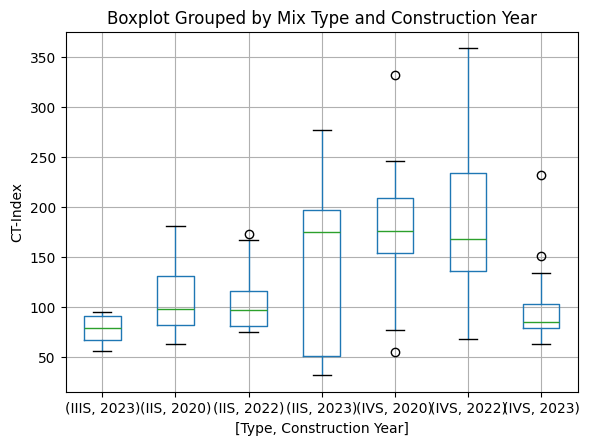

In [24]:
data_or.boxplot(column='Avg. CTindex', by=['Type','Construction Year'])
plt.ylabel('CT-Index')
plt.title('Boxplot Grouped by Mix Type and Construction Year')
plt.suptitle('')
plt.show()

#### One-Way ANOVA for IIS mixtures

In [25]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

type = "IIS"
data_type = data_or[data_or["Type"]==type]
data_type = data_type.rename(columns={'Avg. CTindex': 'Avg_CTindex', 'Avg. Rut Depth':'Avg_Rut_Depth', 'Construction Year': 'Construction_Year'})
data_type = data_type.dropna(subset=['Avg_CTindex', 'Construction_Year'])

# Fit the model
oneway_anova = ols('Avg_CTindex ~ C(Construction_Year)', data=data_type).fit()

# Perform ANOVA table
anova_table = sm.stats.anova_lm(oneway_anova, typ=2)
print(anova_table)

                             sum_sq    df         F    PR(>F)
C(Construction_Year)   12151.932870   2.0  1.698086  0.196628
Residual              135968.778349  38.0       NaN       NaN


#### One-Way ANOVA for IVS mixtures

In [26]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

type = "IVS"
data_type = data_or[data_or["Type"]==type]
data_type = data_type.rename(columns={'Avg. CTindex': 'Avg_CTindex', 'Avg. Rut Depth':'Avg_Rut_Depth', 'Construction Year': 'Construction_Year'})
data_type = data_type.dropna(subset=['Avg_CTindex', 'Construction_Year'])

# Fit the model
oneway_anova = ols('Avg_CTindex ~ C(Construction_Year)', data=data_type).fit()

# Perform ANOVA table
anova_table = sm.stats.anova_lm(oneway_anova, typ=2)
print(anova_table)

                             sum_sq     df          F        PR(>F)
C(Construction_Year)  145673.276171    2.0  23.278678  3.926812e-09
Residual              337921.118604  108.0        NaN           NaN


The p-value for IIS mixtures is 0.197, which is greater than the significance level of 0.05, indicating that there is no statistically significant difference in CT-Index across the different years. In contrast, the p-value for IVS mixtures is well below 0.001, indicating a significant difference in CT-Index between years. To determine which year differs from others, a post hoc analysis was conducted using Tukey's Honestly Significant Difference (HSD) test for pairwise comparisons (Tukey 1949). 

#### Tukey HSD Post Hoc Pairwise Comparison for IVS Mixtures

In [27]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Assume 'value' is numeric DV, 'group' is categorical IV
tukey = pairwise_tukeyhsd(endog=data_type['Avg_CTindex'], groups=data_type['Construction_Year'].astype('category'), alpha=0.05)

print(tukey)

'''
# Optional visualization
tukey.plot_simultaneous(figsize=(8,6)) 
plt.title('Tukey HSD Test - Multiple Comparisons')
plt.show()
'''

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
  2020   2022   4.0032 0.949  -26.8574  34.8639  False
  2020   2023  -80.675   0.0 -116.2023 -45.1477   True
  2022   2023 -84.6782   0.0 -115.5389 -53.8176   True
------------------------------------------------------


"\n# Optional visualization\ntukey.plot_simultaneous(figsize=(8,6)) \nplt.title('Tukey HSD Test - Multiple Comparisons')\nplt.show()\n"

The results show that the CT-Index for 2023 is significantly lower than those for 2020 and 2022, while no significant difference was observed between 2020 and 2022. 

### 2.3. Alternative Approach: Two-Way ANOVA without Interaction



The previous analysis studied the effect of construction year on CT-Index by performing separate one-way ANOVAs within each mix type. This approach treats each mix independently and does not account for the potential consistency of the year effect across different mix types. For instance, the one-way ANOVA indicated a significant year effect for the IVS mixtures but not for the IIS mixtures, which presents a contradiction and complicates drawing conclusions about the overall effect of year on CT-Index.

A more coherent approach is to use a two-way ANOVA, which models the effects of both year and mix type simultaneously. This unified model captures the consistent trend of the year effect across mix types via the main effect of year, while also assessing the influence of mix type. By including all data in a single analysis, two-way ANOVA increases the effective sample size for hypothesis testing, thereby enhancing statistical power and the reliability of the results.

It is worth noting that the dataset has missing values for mix type IIIS in 2020 and 2022, posing challenges for fitting a full two-way ANOVA model that includes interaction between mix type and year. Since the main objective centers on the overall year effect rather than the interaction, we apply the two-way ANOVA without the interaction term. This approach assumes independence between the effects of year and mix type—meaning the effect of year on CT-Index is consistent across mix types. Based on engineering judgment, this assumption is reasonable for the current study.



In [28]:
# Two-way ANOVA

import statsmodels.api as sm
from statsmodels.formula.api import ols

# Example DataFrame
# Assume df with columns: 'value' (numeric), 'group' (categorical)
# df = pd.DataFrame({'value': [...], 'group': [...]})
type = "IVS"
data_type_all = data_or
data_type_all = data_type_all.rename(columns={'Avg. CTindex': 'Avg_CTindex', 'Avg. Rut Depth':'Avg_Rut_Depth', 'Construction Year': 'Construction_Year'})
data_type_all = data_type_all.dropna(subset=['Avg_CTindex', 'Construction_Year', 'Type'])
# Fit the model
twoway_anova = ols('Avg_CTindex ~ C(Construction_Year) + C(Type)', data=data_type_all).fit()

# Perform ANOVA table
anova_table = sm.stats.anova_lm(twoway_anova, typ=2)
print("Two-way ANOVA results:")
print(anova_table)

Two-way ANOVA results:
                             sum_sq     df         F    PR(>F)
C(Construction_Year)   65595.952891    2.0  8.952651  0.000209
C(Type)                33992.649284    2.0  4.639376  0.011045
Residual              567841.473104  155.0       NaN       NaN


The results show that both year and mix type have p-values less than 0.05, indicating statistically significant overall effects of these factors on CT-Index. 

#### Tukey HSD Post Hoc Pairwise Comparison for Two-Way ANOVA

The Tukey HSD post hoc test indicated that the CT-Index in 2023 is significantly lower than in 2020 and 2022, while the IVS mix type has a significantly higher CT-Index than the other types. 

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper   reject
-----------------------------------------------------
  IIIS    IIS  42.7646  0.193 -15.326 100.8552  False
  IIIS    IVS  79.9617 0.0021 24.9428 134.9806   True
   IIS    IVS  37.1971 0.0046    9.73  64.6642   True
-----------------------------------------------------


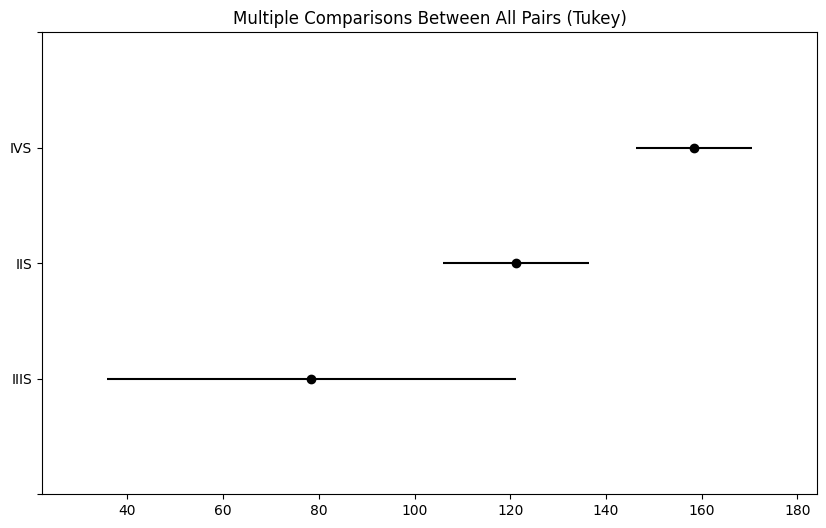

In [29]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# For the 'Type' factor
tukey_type = pairwise_tukeyhsd(endog=data_type_all['Avg_CTindex'],
                               groups=data_type_all['Type'],
                               alpha=0.05)
print(tukey_type)
tukey_type.plot_simultaneous()
plt.show()

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper   reject
-----------------------------------------------------
  2020   2022  12.2949 0.577 -16.7529  41.3428  False
  2020   2023  -47.417 0.001  -78.014 -16.8199   True
  2022   2023 -59.7119   0.0 -86.7867  -32.637   True
-----------------------------------------------------


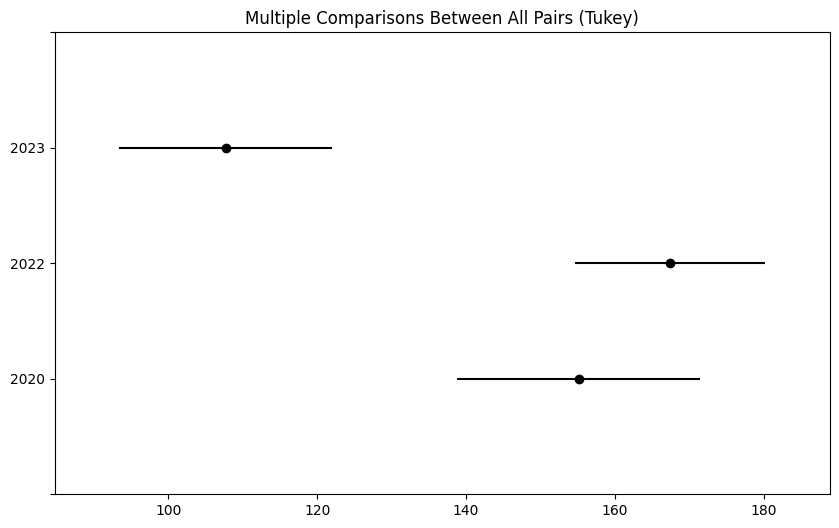

In [30]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# For the 'Type' factor
tukey_type = pairwise_tukeyhsd(endog=data_type_all['Avg_CTindex'],
                               groups=data_type_all['Construction_Year'],
                               alpha=0.05)
print(tukey_type)
tukey_type.plot_simultaneous()
plt.show()